In [1]:
# The Visual Transformer Autoencoder did not work
# THis notebook runs a test to see if it can identify any patch, that is, any location, 
# or if it cannot distinguish the patches.

# I expect that this test will fail initially, and succeed once I have fixed the underlying issue

In [1]:
from visual_transformer import *

In [2]:
# There is no cuda:1 on the smaller penguins.farm
device = torch.device('cuda') #torch.device('cuda:1') # the big machine

In [3]:
brain = DefaultAgentBrain().to(device)

In [4]:
224 / 16

14.0

In [5]:
def get_batch(batchsize=4):
    res = torch.ones((batchsize, 3, 224, 224), device=device)
    res[:, :, :3*14, :3*14] = 0
    return res

In [6]:
# now for the real challenge: input has 1 black patch, output moves it to the right
import random

def get_moving_data(batchsize=4):
    res = torch.ones((batchsize, 3, 224, 224), device=device)
    out = torch.ones((batchsize, 3, 224, 224), device=device)
    for val in range(batchsize):
        x_patch = random.randint(0, 9)
        y_patch = random.randint(0, 12)
        res[val, :, y_patch*14:(y_patch+3)*14, x_patch*14:(x_patch + 3)*14] = 0
        out[val, :, y_patch*14:(y_patch+3)*14, (x_patch + 3)*14:(x_patch + 6)*14] = 0
    return res, out

In [7]:
import matplotlib.pyplot as plt

In [8]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

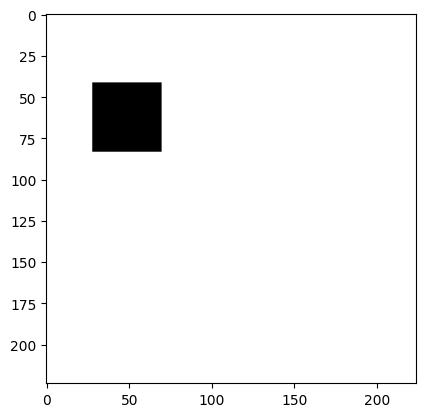

In [9]:
sample, out = get_moving_data()
quick_display(sample[3])

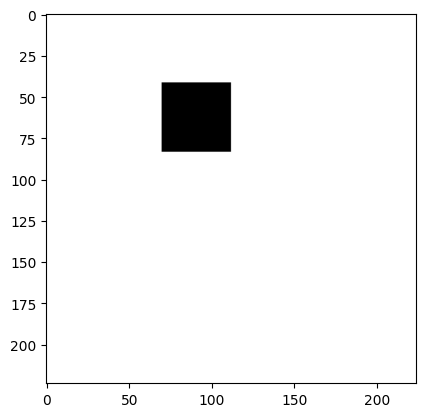

In [10]:
quick_display(out[3])

In [12]:
# now, will the brain learn to produce this image? Or merely splatter gray all over the canvas?

In [13]:
criterion = nn.MSELoss()

In [14]:
optimizer = optim.Adam(brain.parameters(), lr=0.0001, eps=1e-9) #0.0001, betas=(0.9, 0.98), eps=1e-9)

In [15]:
import time

total_batches = 6250*32

total_loss = 0
brain.train()

for b in range(total_batches):
    if b == 0:
        start = time.time()
    #img_set = G.random_full_image_set(restrict_angles=True)
    #img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))
    img_tensor, tgt_tensor = get_moving_data(8) # 4
    batch_size = img_tensor.size()[0]
    text_context = torch.randn((batch_size, 32, 768), device=device) # easier for pretraining to use randn
    recon = brain.img_autoencoder(img_tensor, text_context)
    loss = criterion(recon, tgt_tensor)#img_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
    if b == 0:
        runtime = time.time() - start
        print(f"Time for 1 batch: {runtime} seconds")
    if (b % 100 == 99):
        avg_loss = total_loss / 100
        if avg_loss < 2e-3:
            break # leaving it too long made it break and go back. Clearly this is still not super stable.
        total_loss = 0
        print(f"Avg loss for last 100 batches, at batch {b + 1}: {avg_loss}")
        torch.save(brain.img_enc.state_dict(), f'brain_checkpoints/img_encoder_weights_DEBUG_MOVING_v8_batch{b+1}.pth')
        torch.save(brain.img_dec.state_dict(), f'brain_checkpoints/img_decoder_weights_DEBUG_MOVING_v8_batch{b+1}.pth')

/home/atbolsh/anaconda3/envs/llava-florence/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Time for 1 batch: 0.4522674083709717 seconds
Avg loss for last 100 batches, at batch 100: 0.12376564510166645
Avg loss for last 100 batches, at batch 200: 0.07738211706280708
Avg loss for last 100 batches, at batch 300: 0.07265845403075218
Avg loss for last 100 batches, at batch 400: 0.06066689815372229
Avg loss for last 100 batches, at batch 500: 0.04329429462552071
Avg loss for last 100 batches, at batch 600: 0.03701926484704018
Avg loss for last 100 batches, at batch 700: 0.03319491704925895
Avg loss for last 100 batches, at batch 800: 0.01367041583172977
Avg loss for last 100 batches, at batch 900: 0.006647876207716763
Avg loss for last 100 batches, at batch 1000: 0.00511787436902523
Avg loss for last 100 batches, at batch 1100: 0.004182852727826685
Avg loss for last 100 batches, at batch 1200: 0.003590053333900869
Avg loss for last 100 batches, at batch 1300: 0.003461795449256897
Avg loss for last 100 batches, at batch 1400: 0.003184830168029293
Avg loss for last 100 batches, at b

In [16]:
# Good start.
# Further work: check to make sure that what's being added is added correctly, in the right places, etc.

# Made sure it's correct? Switch to copying someone else's approach.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2431172..1.1239575].


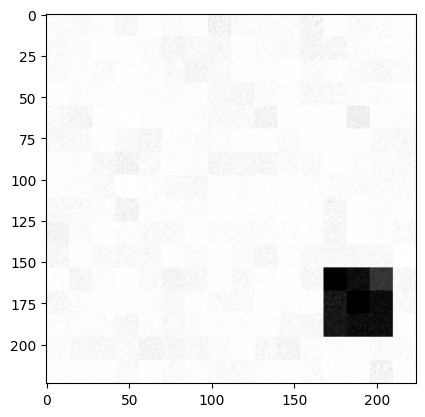

In [20]:
quick_display(recon[2])

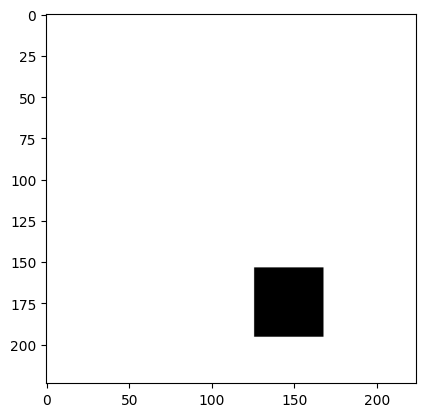

In [21]:
quick_display(img_tensor[2])

In [19]:
b

2299

In [ ]:
# Alternative training regimen

In [11]:
criterion = nn.MSELoss()

In [12]:
# First, learn only the features of the images
optimizer = optim.Adam(list(brain.img_enc.embed.parameters()) + list(brain.img_enc.post_norm.parameters()) + \
                       list(brain.img_dec.linear_layer.parameters()),\
                       lr=0.0001, eps=1e-9) #0.0001, betas=(0.9, 0.98), eps=1e-9)

In [13]:
import time

total_batches = 6250*32

total_loss = 0
brain.train()

for b in range(total_batches):
    if b == 0:
        start = time.time()
    #img_set = G.random_full_image_set(restrict_angles=True)
    #img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))
    img_tensor, tgt_tensor = get_moving_data(8) # 4
    batch_size = img_tensor.size()[0]
    #text_context = torch.randn((batch_size, 32, 768), device=device) # easier for pretraining to use randn
    # per-patch, pure feature learning
    recon = brain.img_dec.linear_layer(brain.img_enc.post_norm(brain.img_enc.embed(img_tensor)))
    # Reconstruction only.
    loss = criterion(recon, img_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
    if b == 0:
        runtime = time.time() - start
        print(f"Time for 1 batch: {runtime} seconds")
    if (b % 100 == 99):
        avg_loss = total_loss / 100
        if avg_loss < 1e-4:
            break # leaving it too long made it break and go back. Clearly this is still not super stable.
        total_loss = 0
        print(f"Avg loss for last 100 batches, at batch {b + 1}: {avg_loss}")
        torch.save(brain.img_enc.state_dict(), f'brain_checkpoints/img_encoder_weights_DEBUG_MOVING_v9_batch{b+1}.pth')
        torch.save(brain.img_dec.state_dict(), f'brain_checkpoints/img_decoder_weights_DEBUG_MOVING_v9_batch{b+1}.pth')

/home/atbolsh/anaconda3/envs/llava-florence/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Time for 1 batch: 4.407585382461548 seconds
Avg loss for last 100 batches, at batch 100: 0.17866853602230548
Avg loss for last 100 batches, at batch 200: 0.07929299585521221
Avg loss for last 100 batches, at batch 300: 0.057575996071100234
Avg loss for last 100 batches, at batch 400: 0.026201967084780335
Avg loss for last 100 batches, at batch 500: 0.010657776854932308
Avg loss for last 100 batches, at batch 600: 0.007031394629739225
Avg loss for last 100 batches, at batch 700: 0.00593542848713696
Avg loss for last 100 batches, at batch 800: 0.00537026503123343
Avg loss for last 100 batches, at batch 900: 0.004986096578650176
Avg loss for last 100 batches, at batch 1000: 0.0046758945239707824
Avg loss for last 100 batches, at batch 1100: 0.004401395590975881
Avg loss for last 100 batches, at batch 1200: 0.004161869566887617
Avg loss for last 100 batches, at batch 1300: 0.003968441637698561
Avg loss for last 100 batches, at batch 1400: 0.003796974124852568
Avg loss for last 100 batches,

In [ ]:
# NOW, we move on to training the position-learning portions

In [14]:
# The initial "time for one batch" was a lie
# The best part (at least for this simple system) is how fast the conv network gets trained (clock time)

# Now let's see how well the position-detectors do . . .

In [15]:
optimizer = optim.Adam(list(brain.img_enc.encoder.parameters()) + list(brain.img_enc.post_norm.parameters()) + \
                       list(brain.img_dec.decoder.parameters()), \
                       lr=0.0001, eps=1e-9)

In [16]:
import time

total_batches = 6250*32

total_loss = 0
brain.train()

for b in range(total_batches):
    if b == 0:
        start = time.time()
    #img_set = G.random_full_image_set(restrict_angles=True)
    #img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))
    img_tensor, tgt_tensor = get_moving_data(8) # 4
    batch_size = img_tensor.size()[0]
    text_context = torch.randn((batch_size, 32, 768), device=device) # easier for pretraining to use randn
    recon = brain.img_autoencoder(img_tensor, text_context)
    loss = criterion(recon, tgt_tensor)#img_tensor)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
    if b == 0:
        runtime = time.time() - start
        print(f"Time for 1 batch: {runtime} seconds")
    if (b % 100 == 99):
        avg_loss = total_loss / 100
        if avg_loss < 2e-3:
            break # leaving it too long made it break and go back. Clearly this is still not super stable.
        total_loss = 0
        print(f"Avg loss for last 100 batches, at batch {b + 1}: {avg_loss}")
        torch.save(brain.img_enc.state_dict(), f'brain_checkpoints/img_encoder_weights_DEBUG_MOVING_v9_batch{b+1}.pth')
        torch.save(brain.img_dec.state_dict(), f'brain_checkpoints/img_decoder_weights_DEBUG_MOVING_v9_batch{b+1}.pth')

Time for 1 batch: 1.1461577415466309 seconds
Avg loss for last 100 batches, at batch 100: 0.08104178756475448
Avg loss for last 100 batches, at batch 200: 0.03570902612060309
Avg loss for last 100 batches, at batch 300: 0.03468307249248028
Avg loss for last 100 batches, at batch 400: 0.03439096212387085
Avg loss for last 100 batches, at batch 500: 0.03427968431264162
Avg loss for last 100 batches, at batch 600: 0.03414483055472374
Avg loss for last 100 batches, at batch 700: 0.03398738943040371
Avg loss for last 100 batches, at batch 800: 0.03375166092067957
Avg loss for last 100 batches, at batch 900: 0.03344093851745129
Avg loss for last 100 batches, at batch 1000: 0.029086667485535143
Avg loss for last 100 batches, at batch 1100: 0.015983937783166768
Avg loss for last 100 batches, at batch 1200: 0.010331702618859708
Avg loss for last 100 batches, at batch 1300: 0.008529000137932598
Avg loss for last 100 batches, at batch 1400: 0.007449511205777526
Avg loss for last 100 batches, at b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08028656..1.0450228].


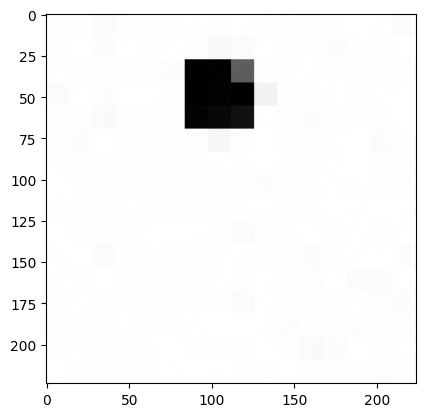

In [17]:
quick_display(recon[2])

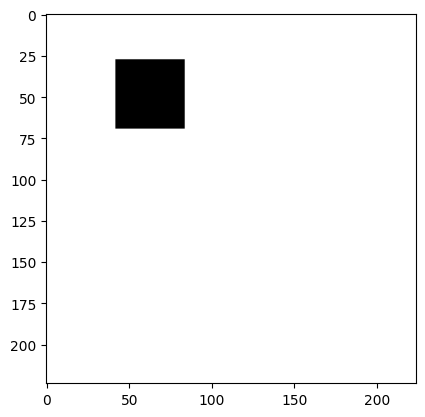

In [18]:
quick_display(img_tensor[2])

In [1]:
# Conclusion: not really worth it.
# It's conceptually cleaner to do things this way, but letting both blocks adjust to 
# each other makes things work faster, especially the final bit of finetuning at the end.

In [2]:
# I may try freezing various layers if (when) I have catastrophic forgetting issues, but I won't bother with
# this stuff for now.